# Gunshot Detection Model - Jupyter Notebook

# Gunshot Audio Detection Model
This notebook trains a Convolutional Neural Network (CNN) to classify audio as either gunshot or non-gunshot.

In [1]:
#%pip install tensorflow

In [2]:
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from collections import defaultdict

ArchiveName = "ModelsSaveIA/GunshotIaModel_v15.h5"

## Entrenamiento

Functions for audio processing, feature extraction, and data augmentation

In [3]:
# Funciones auxiliares para preprocesamiento y augmentación de datos
def extract_spectrogram(file_path, duration=4):
    audio, sample_rate = librosa.load(file_path)
    num_samples = duration * sample_rate

    if len(audio) > num_samples:
        audio = audio[:num_samples]
    else:
        silence = np.zeros(num_samples - len(audio))
        audio = np.concatenate([audio, silence])

    spect = librosa.stft(audio)
    spect_db = librosa.amplitude_to_db(spect)
    return spect_db

def add_noise(audio, noise_factor=0.01):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise


def import_audios(audio_path, metadata, top=2099):
    metadata = metadata.sample(frac=1, random_state=random.randint(1, 10000)).reset_index(drop=True)
    features, labels = [], []
    num_gun = 0
    class_counts = defaultdict(int)  # Contador para las clases distintas de 6

    # Usar tqdm para mostrar la barra de progreso
    for index, row in tqdm(metadata.iterrows(), total=metadata.shape[0], desc="Importando audios"):
        file_name = os.path.join(audio_path, f"{row['fold']}", row['filename'])
        class_id = row['classID']
        class_label = 1.0 if class_id == 50 else 0.0

        # Manejo de la clase 6 (disparos)
        if class_label == 1.0:
            if num_gun >= top:
                continue  # Limitar el número de muestras de disparos
            num_gun += 1
        else:
            # Manejo de las demás clases
            if class_counts[class_id] >= top // (metadata['classID'].nunique() - 1):
                continue  # Limitar de manera equitativa el número de muestras de cada clase no disparo
            class_counts[class_id] += 1

        try:
            data = extract_spectrogram(file_name)
            features.append(data)
            labels.append(class_label)
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    # Resumen de clases procesadas
    print(f"Total samples: {len(features)}, Guns: {num_gun}, Non-gun breakdown: {dict(class_counts)}")
    return np.array(features), np.array(labels)

def compute_optimal_threshold(y_test, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    return thresholds[optimal_idx]

## Data Loading and Preprocessing
Loading metadata and importing audio files

In [4]:
# Cargar metadatos y datos
metadata = pd.read_csv('../../../Audio Tesis/IA Dataset audio/audio_dataset.csv')
audio_path = '../../../Audio Tesis/IA Dataset audio'
features, labels = import_audios(audio_path, metadata)

Importando audios:   0%|          | 0/5941 [00:00<?, ?it/s]C:\Users\HudayPlata\AppData\Local\Temp\ipykernel_68508\256775473.py:13: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spect_db = librosa.amplitude_to_db(spect)
Importando audios: 100%|██████████| 5941/5941 [01:59<00:00, 49.69it/s] 


Total samples: 4149, Guns: 2099, Non-gun breakdown: {3: 41, 21: 41, 13: 41, 38: 41, 4: 41, 11: 41, 49: 41, 5: 41, 41: 41, 8: 41, 29: 41, 48: 41, 7: 41, 39: 41, 12: 41, 14: 41, 46: 41, 19: 41, 24: 41, 0: 41, 47: 41, 1: 41, 40: 41, 16: 41, 2: 41, 10: 41, 34: 41, 20: 41, 9: 41, 33: 41, 44: 41, 31: 41, 37: 41, 36: 41, 25: 41, 28: 41, 32: 41, 6: 41, 27: 41, 26: 41, 23: 41, 42: 41, 18: 41, 15: 41, 45: 41, 43: 41, 30: 41, 35: 41, 22: 41, 17: 41}


## Data Preparation
Converting features to NumPy arrays and splitting data into training and test sets

In [5]:
# Convertir las listas en arrays de numpy
X = features[..., np.newaxis]  # Agregar dimensión de canal

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

# Calcular pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

## Model Definition
Creating a Convolutional Neural Network for audio classification

In [2]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Crear el modelo CRNN
import tensorflow as tf
import visualkeras


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(1025, 173, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2)),  # (1025, 86)
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # (512, 43)
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),  # (256, 43)

    tf.keras.layers.Reshape((43, -1)),  # → secuencia de 43 pasos temporales

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, dropout=0.3, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 1025, 173, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1025, 173, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1025, 86, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 1025, 86, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1025, 86, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 512, 43, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 512, 43, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512, 43, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 256, 43, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 43, 16384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 43, 64)         │     3,152,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,180,225 (12.13 MB)

 Trainable params: 3,180,001 (12.13 MB)

 Non-trainable params: 224 (896.00 B)

None


## Model Training
Training the model with class weights to handle imbalanced data

In [7]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=16, class_weight=class_weight_dict)

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 765s 4s/step - accuracy: 0.7739 - loss: 0.4885
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 613s 3s/step - accuracy: 0.9025 - loss: 0.2520
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.9148 - loss: 0.2213
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.9339 - loss: 0.1761
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.9240 - loss: 0.1845
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9188 - loss: 0.2066
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.9492 - loss: 0.1300
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.9512 - loss: 0.1476
Epoch 9/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 786s 4s/step - accuracy: 0.9633 - loss: 0.1228
Epoch 10/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.9547 - loss: 0.1252


## Model Saving and Evaluation
Saving the trained model and evaluating performance metrics

In [8]:
model.save(ArchiveName)
# Evaluar el modelo
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {score[1]}")

# Predicciones y probabilidades
y_pred_prob = model.predict(X_test)
y_pred_class = (y_pred_prob > 0.5).astype("int32")

Accuracy: 0.9518072009086609
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 414ms/step


## Performance Visualization
Visualizing model performance with confusion matrix, classification report, and ROC curve

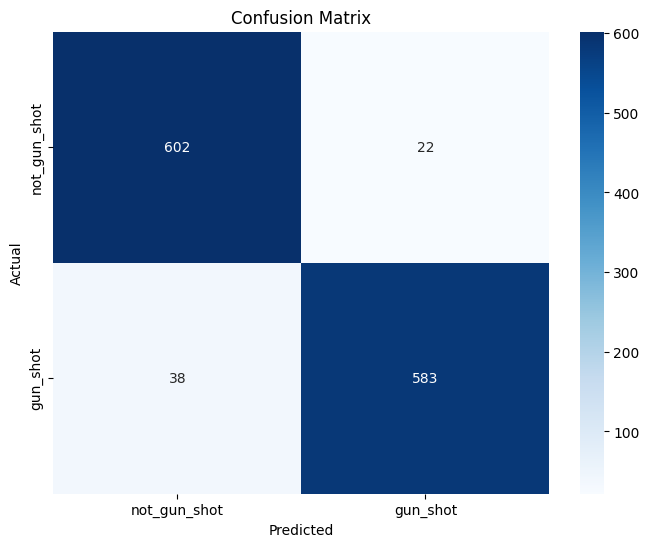

              precision    recall  f1-score   support

not_gun_shot       0.94      0.96      0.95       624
    gun_shot       0.96      0.94      0.95       621

    accuracy                           0.95      1245
   macro avg       0.95      0.95      0.95      1245
weighted avg       0.95      0.95      0.95      1245



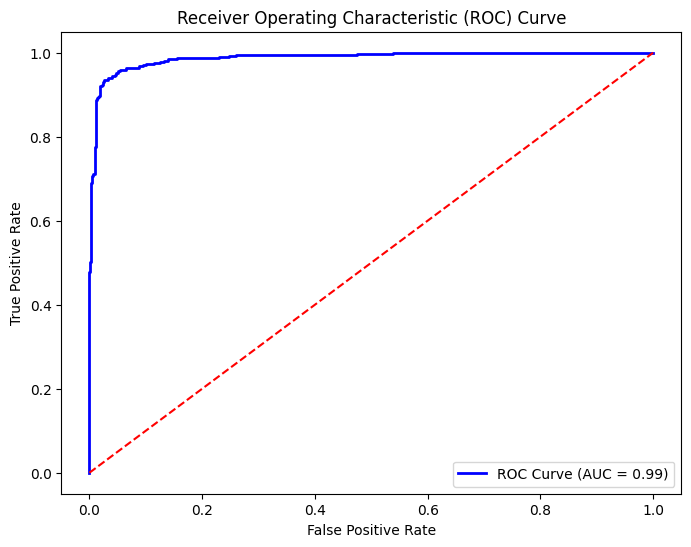

Optimal Threshold: 0.5992147922515869


In [9]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['not_gun_shot', 'gun_shot'], yticklabels=['not_gun_shot', 'gun_shot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred_class, target_names=['not_gun_shot', 'gun_shot']))

# Curva ROC y cálculo de AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Umbral óptimo
optimal_threshold = compute_optimal_threshold(y_test, y_pred_prob)
print(f"Optimal Threshold: {optimal_threshold}")

## Training History Visualization
Visualizing training progress over epochs

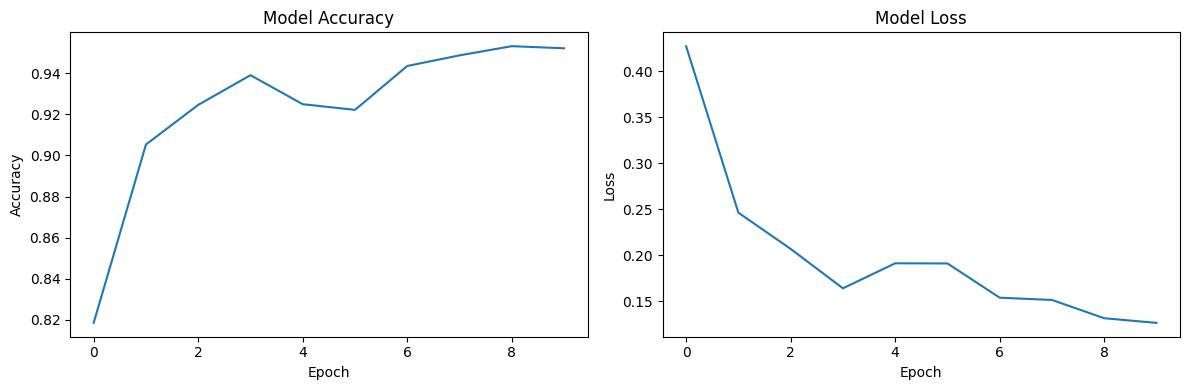

In [10]:
# Visualizar el historial de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()